In [1]:
%matplotlib inline
from configparser import ConfigParser
import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pprint import pprint
from skimage.measure import compare_ssim

In [2]:
## constants
############

CONFIG_PATH = './conf/config.ini'

In [3]:
## config
#########

config = ConfigParser()

config.read(CONFIG_PATH)
sequence_config = dict(config['Sequence'])
tracking_config = dict(config['Tracking'])

sequence_config['frame_rate'] = config.getint("Sequence","frame_rate")
sequence_config['seq_length'] = config.getint("Sequence","seq_length")
sequence_config['img_width'] = config.getint("Sequence","img_width")
sequence_config['img_height'] = config.getint("Sequence","img_height")

tracking_config['scaled_height'] = config.getint("Tracking","scaled_height")
tracking_config['scaled_width'] = config.getint("Tracking","scaled_width")
tracking_config['memory'] = config.getint("Tracking","memory")
tracking_config['similarity_threshold'] = config.getfloat("Tracking","similarity_threshold")
tracking_config['distance_threshold'] = config.getfloat("Tracking","distance_threshold")
tracking_config['confidence_threshold'] = config.getfloat("Tracking","confidence_threshold")


sift = cv2.xfeatures2d.SIFT_create()
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

In [4]:
## input
########

# pos       name                    description
# 1      frame number           frame in which the object is present
# 2      identity number        trajectory id (-1 default for no track)
# 3      bounding box x         x value from top left of bounding box
# 4      bounding box y         y value from top left of bounding box
# 5      bounding box width     width of bounding box in pixels
# 6      bounding box height    height of bounding box in pixels
# 7      confidence score      class detection confidence

In [5]:
## output
#########

# pos       name                    description
# 1      frame number           frame in which the object is present
# 2      identity number        trajectory id (-1 default for no track)
# 3      bounding box x         x value from top left of bounding box
# 4      bounding box y         y value from top left of bounding box
# 5      bounding box width     width of bounding box in pixels
# 6      bounding box height    height of bounding box in pixels
# 7      confidence score*      class detection confidence (gt: 1 or 0)
# 8      class*                 type of class (1 for pedestrian)
# 9      visibility*            percent visible (percent occluded = 1-visibility)

#        *no need to output these values, will be ignore by evaluator

In [6]:
class Point(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y

In [7]:
class Distance(object):
    
    @staticmethod
    def l2_norm(obj1, obj2):
        p1, p2 = None, None
        
        if type(obj1) == Box:
            p1 = obj1.centroid
        elif type(obj1) == Point:
            p1 = obj1
        
        if type(obj1) == Box:
            p2 = obj2.centroid
        elif type(obj1) == Point:
            p2 = obj2
        
        return math.sqrt((p2.x-p1.x)**2 + (p2.y-p1.y)**2)
    
    @staticmethod
    def jaccard(obj1, obj2):
        
        if type(obj1) == Box and type(obj2) == Box:
            
            # just to make this a little more intuitive
            box1, box2 = obj1, obj2
            
            # to make this easier we'll create two arrays, [x1, y1, x2, y2], s.t.
            # (x1, y1) is the top left point for a box and (x2, y2) is the bottom right
            a = [box1.x, box1.y, box1.x + box1.w, box1.y + box1.h]
            b = [box2.x, box2.y, box2.x + box2.w, box2.y + box2.h]
            
            # intersection
            
            # find the boundary of the intersection between the two boxes
            x1 = max(a[0], b[0]) # rightmost x of the top left points
            y1 = max(a[1], b[1]) # lowest y of the top left points
            x2 = min(a[2], b[2]) # leftmost x of the bottom right points
            y2 = min(a[3], b[3]) # highest y of the bottom right points
            
            # find the area of the intersection
            width = (x2 - x1)
            height = (y2 - y1)
            
            # if no overlap don't bother going further, return 0
            if width <= 0 or height <= 0:
                return 0
            
            area_of_intersection = width * height
            
            # area of union
            
            # this is easy, you don't need to know where the boxes are, since you've
            # already calculated the intersection. if you just add the total area
            # of box_a and the the area of box_b you've counted the intersection
            # twice, so just subtract the intersection once and you have the answer
            a_area = (a[2] - a[0]) * (a[3] - a[1])
            b_area = (b[2] - b[0]) * (b[3] - b[1])
            
            area_of_union = a_area + b_area - area_of_intersection
            
            # protect again division by zero
            epsilon = 1e-5
            
            iou = area_of_intersection / (area_of_union + epsilon)
            return iou
    
        elif type(obj1) == numpy.ndarray and type(obj2) == numpy.ndarray:
            descriptors1, descriptors2 = obj1, obj2
            
            # brute force feature matching using manhattan distance
        
            bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

            matches = bf.match(descriptors_1, descriptors_2)
            matches = sorted(matches, key = lambda x:x.distance)

            # TODO do we want to cutoff at a threshold?
            
            intersection = len(matches)
            union = len(descriptors1)+len(descriptors2)-intersection

            epsilon = 1e-5
            
            return intersection / (union+epsilon)
    
    @staticmethod
    def sift(box1, box2):
        
        img_path = sequence_config['img_path']
        
        # get filepaths
        
        img1_path = os.path.join(img_path, "%06d.jpg" % box1.frame)
        img2_path = os.path.join(img_path, "%06d.jpg" % box2.frame)
        
        # read image files as grayscale
        
        color_img1 = cv2.imread(img1_path)
        color_img2 = cv2.imread(img2_path)
        
        gray_img1 = cv2.cvtColor(color_img1, cv2.COLOR_BGR2GRAY)
        gray_img2 = cv2.cvtColor(color_img2, cv2.COLOR_BGR2GRAY)
        
        # cut out the firt object from the first image
        
        p1, p2 = box1.coords
        start_x, start_y = int(round(p1.x)), int(round(p1.y))
        end_x, end_y = int(round(p2.x)),int(round(p2.y))
        
        crop1 = gray_img1[start_y:end_y, start_x:end_x]
        
        # cut out the second object from the second image
        
        p1, p2 = box2.coords
        start_x, start_y = int(round(p1.x)), int(round(p1.y))
        end_x, end_y = int(round(p2.x)),int(round(p2.y))
        
        crop2 = gray_img2[start_y:end_y, start_x:end_x]
        
        # TODO consider experimenting with sharpening, contrast
        
        # find keypoints and descriptors        
        # https://docs.opencv.org/4.3.0/da/df5/tutorial_py_sift_intro.html
        # https://www.analyticsvidhya.com/blog/2019/10/detailed-guide-powerful-sift-technique-image-matching-python/
        
        try:
            keypoints_1, descriptors_1 = sift.detectAndCompute(crop1,None)        
            keypoints_2, descriptors_2 = sift.detectAndCompute(crop2,None)
        except Exception as ex:
            print("\n\nBox1: %s, \nBox 2: %s\n%s\n" % (str(box1), str(box2), str(ex)))
            return 0 

        if len(keypoints_1) == 0 or len(keypoints_2) == 0:
            # sift may not detect keypoints in an image with a dark 
            # foreground on a dark background, or a light foreground
            # light background. in this case, equalize the histogram
            # to enhance contrast, and try again.
            
            try:
                equ1 = cv2.equalizeHist(crop1)
                equ2 = cv2.equalizeHist(crop2)
                keypoints_1, descriptors_1 = sift.detectAndCompute(equ1,None)        
                keypoints_2, descriptors_2 = sift.detectAndCompute(equ2,None)
                
                print(len(keypoints_1), len(keypoints_2))
            except Exception as ex:
                # print("\n\nBox1: %s, \nBox 2: %s\n%s\n" % (str(box1), str(box2), str(ex)))                        
                return 0 
        
        # FLANN feature matcher
        
        try:
            matches = flann.knnMatch(descriptors_1,descriptors_2,k=2)
        except Exception as ex:
            # print(box1, keypoints_1, box2, keypoints_2)
            return 0

        good_matches = []

        # ratio test as per Lowe's paper
        for i,(m,n) in enumerate(matches):
            if m.distance < 0.7*n.distance:
                good_matches.append(m)
        
        epsilon = 1e-5
        
        try:
            return len(good_matches) / (len(matches)+epsilon)
        except Exception as ex:
            print(ex)

    @staticmethod
    def ssim(box1, box2):
        
        img_path = sequence_config['img_path']
        
        # get filepaths
        
        img1_path = os.path.join(img_path, "%06d.jpg" % box1.frame)
        img2_path = os.path.join(img_path, "%06d.jpg" % box2.frame)
        
        # read image files as grayscale
        
        color_img1 = cv2.imread(img1_path)
        color_img2 = cv2.imread(img2_path)
        
        gray_img1 = cv2.cvtColor(color_img1, cv2.COLOR_BGR2GRAY)
        gray_img2 = cv2.cvtColor(color_img2, cv2.COLOR_BGR2GRAY)
        
        # cut out the firt object from the first image
        
        p1, p2 = box1.coords
        start_x, start_y = int(round(p1.x)), int(round(p1.y))
        end_x, end_y = int(round(p2.x)),int(round(p2.y))
        
        crop1 = gray_img1[start_y:end_y, start_x:end_x]
        
        # cut out the second object from the second image
        
        p1, p2 = box2.coords
        start_x, start_y = int(round(p1.x)), int(round(p1.y))
        end_x, end_y = int(round(p2.x)),int(round(p2.y))
        
        crop2 = gray_img2[start_y:end_y, start_x:end_x]
        
        try:
            eq1 = crop1 # cv2.equalizeHist(crop1)
            eq2 = crop2 # cv2.equalizeHist(crop2)
        except Exception as ex:
            print(ex)
            return 0

        dim = (tracking_config["scaled_width"], tracking_config["scaled_height"])
                
        try:
            scaled1 = cv2.resize(eq1, dim, interpolation=cv2.INTER_AREA)
            scaled2 = cv2.resize(eq2, dim, interpolation=cv2.INTER_AREA)
        except Exception as ex:
            print(ex)
            return 0
        
        try:
            score, diff = compare_ssim(scaled1, scaled2, full=True)
            # diff = (diff*255).astype("unit8") # interesting, but I don't need this information
            return score
        except Exception as ex:
            print(ex)
            return 0

In [8]:
class Box(object):
    def __init__(self, x, y, w, h, index=None, frame=None, track_id=None, conf=None):
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.index = index
        self.frame = frame
        self.track_id = track_id
        self.conf = conf
    
    @property
    def coords(self):
        return(Point(self.x, self.y), Point(self.x+self.w, self.y+self.h))
    
    @property
    def centroid(self):
        return Point(self.x+(self.w*0.5), self.y+(self.h*0.5))

    def copy(self, offset_x=0, offset_y=0):
        
        # make sure you don't go outside the image bounds
        # i'm sure there's a more elegant way of doing this
        
        x1, y1 = self.x+offset_x, self.y+offset_y
        x2, y2 = x1+self.w, y1+self.h
        
        image_width = sequence_config['img_width']
        image_height = sequence_config['img_height']
        w, h = self.w, self.h
        
        if x1 < 0:
            x1 = 0
        if y1 < 0:
            y1 = 0
        if x2 > image_width:
            w = image_width - self.x
        if y2 > image_height:
            h = image_height - self.y
        
        return Box(x1, y1, w, h, self.index, self.frame, self.track_id, self.conf)
    
    def __repr__(self):
        return "Box(%s, %s, %s, %s, %s, %s, %s, %s)" % (
            self.x, self.y, self.w, self.h, self.index, self.frame, self.track_id, self.conf
        )
    
    def __str__(self):
        return "index: %s, frame: %s, track: %s, x: %s, y: %s, w: %s, h: %s, conf: %s" % (
            self.index, self.frame, self.track_id, self.x, self.y, self.w, self.h, self.conf
        )

In [9]:
class Track(object):
    counter = 1
    
    def __init__(self, o):
        self.id = Track.counter
        Track.counter += 1
        
        if type(o) == list:
            boxes = o
            self.boxes = boxes
        elif type(o) == Box:
            box = o
            self.boxes = [box]
            
        self.is_active = True
    
    def add(self, box):
        box.track_id = self.id
        self.boxes.append(box)
    
    @staticmethod
    def angle(box1, box2):
        
        p1 = box1.centroid
        p2 = box2.centroid

        rads = math.atan2(p1.y-p2.y, p1.x-p2.x)
        # deg = math.degrees(rads)
        # return rads
        return rads
    
    @staticmethod
    def distance(box1, box2):
            
        p1 = box1.centroid
        p2 = box2.centroid

        distance = math.hypot((p2.x-p1.x),(p2.y-p1.y))
        # distance = sqrt((x2-x1)**2 + (y2-y1)**2)
        
        return distance
    
    def predict(self, frame_id):
        end_of_track = self.boxes[-1] # this is the last box added to the track
        
        frames_since_last_match = frame_id - end_of_track.frame
        
        if frames_since_last_match > tracking_config['memory']:
            # forget this track if it's outside the memory window
            return None
        
        if len(self.boxes)==1:
            predicted_location = end_of_track.copy()
        else:
            second_to_end = self.boxes[-2]
            
            angle = Track.angle(second_to_end, end_of_track)
            distance = Track.distance(second_to_end, end_of_track)
            
            # experiment, let's decrease the motion with each missing detection
            
            if frames_since_last_match < 1:
                frames_since_last_match = 1
                
            if tracking_config['distance_measure'] == 'sift':
                distance = 1
            else:
                distance = distance * 1/frames_since_last_match
            
            # end of experiment section
            
            offset_x = distance*math.sin(angle)
            offset_y = distance*math.cos(angle)
            
            # predicted_location = current.copy() # match last location
            predicted_location = end_of_track.copy(offset_x, offset_y) # estimate trajectory
            
        # predicted_location.frame += 1

        return predicted_location

    def __repr__(self):
        return "Track([<__main__.Box>]) count: %s" % len(self.boxes)
    
    def __str__(self):
        return "TrackID: %s, Frames: %s-%s" % (
            self.id, self.boxes[0].frame, self.boxes[-1].frame
        )
    
    def __len__(self):
        return len(self._boxes)

In [10]:
class Frame(object):
    def __init__(self, number, boxes=None):
        self.id = number
        
        if boxes is None:
            boxes = []
        
        self._boxes = boxes
    
    def add(self, box):
        if type(box) == Box:
            self._boxes.append(box)
        elif type(box) == list:
            self._boxes.extend(boxes)
    
    @property
    def objects(self):
        return self._boxes
    
    def __repr__(self):
        return "Frame(%s, [<__main__.Box>]) count: %s" % (self.id, len(self.boxes))
    
    def __str__(self):
        return "FrameID: %s, Count: %s" % (self.id, len(self.boxes))
    
    def __len__(self):
        return len(self._boxes)

In [11]:
class Detections(object):
    def __init__(self, data_path=tracking_config['detections_path']):
        self.data_path = data_path
        self.mean_width = None
        self.mean_height = None
        self._df = None
        self._frames = {}
        self.start_index = None
        self.end_index = None
        self.count = sequence_config['seq_length']
        self._pos = None
        self._load()
    
    def _load(self, conf_threshold=tracking_config['confidence_threshold']):
        
        header_list = ['frame','trajectory','x','y','w','h','confidence']
        dtype = {'frame':int,'trajectory':int,'x':float,'y':float,'w':float,'h':float,'confidence':float}
        
        df = pd.read_csv(self.data_path, names=header_list, dtype=dtype)

        # filter out low confidence detections
        
        self._df = df[df["confidence"] >= conf_threshold]
        
        self.mean_width = self._df["w"].mean()
        self.mean_height = self._df["h"].mean()

        # get the indices for the first and last frames

        self.start_index = self._df['frame'].min()
        self.end_index = self._df['frame'].max() + 1

        for i in range(self.start_index, self.end_index):
            self._frames[i] = self._df.loc[df['frame']==i,:]
    
    def __iter__(self):
        return self
    
    def __next__(self):
        return self.next()
    
    def next(self):
        while True:
            if self._pos is None:
                self._pos = self.start_index        
            elif self._pos < self.end_index:
                current, self._pos = self._pos, self._pos + 1
                current_frame = self._frames[current]

                detection_boxes = []

                for i, detection in current_frame.iterrows():                
                    frame_no, traj_no, x, y, w, h, conf = detection
                    box = Box(x, y, w, h, int(i), int(frame_no), -1, conf)
                    detection_boxes.append(box)

                return Frame(current, detection_boxes)
            else:
                # self._pos = None
                raise StopIteration()
        
    def __repr__(self):
        return "Detections(%s, %s, %s, %s, %s, %s)" % (
            self.data_path, self.mean_width, self.mean_height, 
            self.start_index, self.end_index, self.count
        )
    
    def __str__(self):
        return "path: %s, name: %s, mean_width: %s, mean_height: %s, start_index: %s, end_index: %s, count: %s)" % (
            self.data_path, sequence_config['name'], 
            self.mean_width, self.mean_height, 
            self.start_index, self.end_index, self.count
        )
    
    def __len__(self):
        # TODO this is really the length of the frames, that's how
        # I use it in trajectories... should rethink this
        return self.count

In [12]:
class Trajectories(object):
    def __init__(self):
        # reset track counter
        Track.counter = 1
        self._tracks = {}
        self.detections = Detections()
        
        self.dists = []
        self.jaccards = []
        self.sifts = []
        self.ssims = []
    
    def add(self, o):
        if type(o) == Box:
            box = o
            track = Track(box)
            box.track_id = track.id
            self._tracks[track.id] = track
        if type(o) == Track:
            track = o
            self._tracks[track.id] = track
    
    def _ssid_matching(self, predictions, current_frame):
            similarity_vector = []
            computed = []

            for box_a in predictions:
                for box_b in current_frame.objects:

                    if box_a.index is None or box_b.index is None:
                        raise Exception("Boundary index may not be None.")                    

                    this_pair = set([box_a.index, box_b.index])

                    if this_pair not in computed:

                        distance_threshold = tracking_config['distance_threshold']
                        similarity_threshold = tracking_config['similarity_threshold']

                        distance = Distance.l2_norm(box_a, box_b)
                        # distance_ratio = (distance_threshold - distance) / distance_threshold

                        if distance <= distance_threshold:

                            similarity1 = Distance.ssim(box_a, box_b)
                            similarity2 = Distance.sift(box_a, box_b)                            
                            # mean_sim = (similarity1 + similarity2)/2
                            
                            # jaccard = Distance.jaccard(box_a, box_b)
                            # mean_dist = (distance_ratio+jaccard) / 2

                            # self.dists.append(distance_ratio)
                            # self.jaccards.append(jaccard)
                            self.sifts.append(similarity2)
                            self.ssims.append(similarity1)
                            
#                             if mean_sim >= similarity_threshold:

#                                 similarity_vector.append((mean_sim, box_a, box_b))
                            
#                             elif mean_dist >= 0.6:
                                
#                                 similarity_vector.append((mean_sim/2.1, box_a, box_b))

                            if similarity1 >= similarity_threshold:

                                similarity_vector.append((similarity1, box_a, box_b))

                        computed.append(this_pair)

            similarity_vector.sort(key=lambda x: x[0], reverse=True)

            matching_pairs = []
            matched_objects = set([])

            for distance, box_1, box_2 in similarity_vector:

                # we want to ensure that we only return the top matches, so we keep track
                # of the objects already matched and ignore less similar matches for these objects

                if box_1.index not in matched_objects and box_2.index not in matched_objects:                

                    match = (box_1, box_2)
                    matching_pairs.append(match)

                    matched_objects.add(box_1.index)
                    matched_objects.add(box_2.index)

            # unmatched detections in current frame need to become new tracks

            if len(self.ssims)%100 == 0:                
            
                bins = np.linspace(0,1,30)
                plt.hist([self.jaccards,self.dists], bins, label=['IOU','L2'])  # `density=False` would make counts
                plt.legend(loc='upper right')
                plt.show()

                plt.hist([self.sifts,self.ssims], bins, label=['SIFT','SSIM'])  # `density=False` would make counts
                plt.legend(loc='upper right')
                plt.show()
            
            #####
            
            unmatched = set(
                [box for box in current_frame.objects if box.index not in matched_objects]
            )

            for box in unmatched:
               self.add(box)

            print("%s:%s/%s" % (current_frame.id, len(matching_pairs), len(self._tracks),), end =" ")

            return matching_pairs
        
    
    def _sift_matching(self, predictions, current_frame):
        measure = tracking_config['distance_measure']
        
        if measure != 'sift':
            return self._measure(predictions, current_frame)
                
        similarity_vector = []
        computed = []
        
        for box_a in predictions:
            for box_b in current_frame.objects:
                
                if box_a.index is None or box_b.index is None:
                    raise Exception("Boundary index may not be None.")                    
                    
                this_pair = set([box_a.index, box_b.index])
                
                if this_pair not in computed:
                    
                    distance_threshold = tracking_config['distance_threshold']
                    similarity_threshold = tracking_config['similarity_threshold']

                    distance = Distance.l2_norm(box_a, box_b)
                    distance_ratio = (distance_threshold - distance) / distance_threshold
                                        
                    if distance <= distance_threshold:
                        
                        similarity = Distance.sift(box_a, box_b)
                        jaccard = Distance.jaccard(box_a, box_b)
                        
                        # if similarity > similarity_threshold:
                            
                        # little experiment to help match dark low contrast patches
                        distance_weight = 1 # multiplier to increase or decrease importance of distance
                        similarity_weight = 1 # multiplier to increase or decrease importance of image similarity
                        jaccard_weight = 1

                        mean_similarity = (
                            (similarity_weight*similarity + distance_weight*distance_ratio + jaccard_weight*jaccard) / (similarity_weight+distance_weight+jaccard_weight)
                        )                            

                        similarity_vector.append((mean_similarity, box_a, box_b))
                        
                    computed.append(this_pair)

        similarity_vector.sort(key=lambda x: x[0], reverse=True)
        
        matching_pairs = []
        matched_objects = set([])

        for distance, box_1, box_2 in similarity_vector:
            
            # we want to ensure that we only return the top matches, so we keep track
            # of the objects already matched and ignore less similar matches for these objects
            
            if box_1.index not in matched_objects and box_2.index not in matched_objects:                
            
                match = (box_1, box_2)
                matching_pairs.append(match)
                
                matched_objects.add(box_1.index)
                matched_objects.add(box_2.index)
        
        # unmatched detections in current frame need to become new tracks
        
        unmatched = set(
            [box for box in current_frame.objects if box.index not in matched_objects]
        )
        
        for box in unmatched:
           self.add(box)
        
        print("%s:%s/%s" % (current_frame.id, len(matching_pairs), len(self._tracks),), end =" ")
        
        return matching_pairs
    
    def _matching(self, predictions, current_frame):
        measure = tracking_config['distance_measure']
        
        if mesaure == 'sift':
            distance_func = Distance.sift
        elif measure == 'euclidean':
            distance_func = Distance.l2_norm
        elif measure == 'iou':
            distance_func = Distance.jaccard
        else:
            return
    
        sim_vector = []
        computed = []
        
        for box_a in predictions:
            for box_b in current_frame.objects:
                
                if box_a.index is None or box_b.index is None:
                    raise Exception("Boundary index may not be None.")                    
                    
                this_pair = set([box_a.index, box_b.index])
                
                if this_pair not in computed:
                    
                    similarity = distance_func(box_a, box_b)
                    
                    sim_threshold = tracking_config['similarity_threshold']
                    
                    if measure == 'euclidean':
                        if similarity <= sim_threshold:
                            
                            ### little experiment, let's make it a ratio #############
                            similarity = (sim_threshold - similarity) /  sim_threshold
                            ##########################################################
                            
                            sim_vector.append((similarity, box_a, box_b))
                    else:
                        if similarity >= sim_threshold:
                            sim_vector.append((similarity, box_a, box_b))
                        
                    computed.append(this_pair)

        if measure == 'euclidean':            
            # sim_vector.sort(key=lambda x: x[0])
            sim_vector.sort(key=lambda x: x[0], reverse=True)
        else:
            sim_vector.sort(key=lambda x: x[0], reverse=True)

        # print([x[0] for x in sim_vector[::3]], end=", ")
            
        matching_pairs = []
        matched_objects = set([])

        for distance, box_1, box_2 in sim_vector:
            
            # we want to ensure that we only return the top matches, so we keep track
            # of the objects already matched and ignore less similar matches for these objects
            
            if box_1.index not in matched_objects and box_2.index not in matched_objects:                
            
                match = (box_1, box_2)
                matching_pairs.append(match)
                
                matched_objects.add(box_1.index)
                matched_objects.add(box_2.index)
        
        # unmatched detections in current frame need to become new tracks
        
        unmatched = set(
            [box for box in current_frame.objects if box.index not in matched_objects]
        )
        
        for box in unmatched:
            self.add(box)
        
        print(len(self._tracks), end =" ")
        
        return matching_pairs
    
    def calculate(self, start=0, end=None):
        if end is None:
            end = len(self.detections)
            
        # for frame in self.detections[start:end]: # Detections not subscriptable
        
        for frame in self.detections:
            # TODO fix this mess with dataframes
            df = self.detections._frames[frame.id]
            
            if len(self._tracks)==0:
                for box in frame.objects:
                    self.add(box)
                    
                    # TODO fix this mess with dataframes
                    df.loc[box.index, "trajectory"] = box.track_id
                continue

            predictions = []
            for track_id, track in self._tracks.items():
                prediction = track.predict(frame.id)
                if prediction is not None:
                    predictions.append(prediction)

            #matching_pairs = self._matching(predictions, frame)
            #matching_pairs = self._sift_matching(predictions, frame)
            matching_pairs = self._ssid_matching(predictions, frame)
            
            for box_1, box_2 in matching_pairs:
                track = self._tracks[box_1.track_id]
                track.add(box_2)
                
                # TODO fix this mess with dataframes
                df.loc[box_2.index, "trajectory"] = box_1.track_id

    def output(self, path=None):
        if path is None:            
            for track_id, boxes in self._tracks.items():
                print(track_id, boxes)
        else:
            # write
            pass
    
    def __len__(self):
        return len(self._tracks)

In [ ]:
trajectories = Trajectories()
trajectories.calculate()
trajectories.output()

In [14]:
from random import randint
colors = []
offset = 50
for i in range(100):
    r = randint(0,255)
    g = randint(0,255)
    b = randint(0,255)
    
    if r < offset or g < offset or b < offset:
        colors.append(((r,g,b),(r+offset, g+offset, b+offset)))
    else:
        colors.append(((r,g,b),(r-offset, g-offset, b-offset)))

In [15]:
video_frames = []
img_path = "img1"

img_filenames = [f for f in os.listdir(img_path) if os.path.isfile(os.path.join(img_path, f))]
img_filenames.sort()

for img_filename in img_filenames:
    
    if img_filename == '.empty':
        continue
    
    frame_id = int(img_filename.split('.')[0])
    frame = trajectories.detections._frames[frame_id]
    img = cv2.imread(os.path.join(img_path, img_filename))
    for index, (frame,track,x,y,w,h,conf) in frame.iterrows():
        
        track, x, y, w, h = int(track), int(x), int(y), int(w), int(h)
        if track < 1:
            continue
        
        color_index = track % 100
        box_color, text_color = colors[color_index]
        
        top_left = (x, y)
        bottom_right = (x+w, y+h)
        thickness = 2
        
        cv2.rectangle(img, top_left, bottom_right, box_color, thickness)
        
        font = cv2.FONT_HERSHEY_SIMPLEX
        anchor_point = (x, y+20)
        scale = 0.75
        thickness = 2
        line_type = cv2.LINE_AA
        
        cv2.putText(img, str(track), anchor_point, font, scale, text_color, thickness, line_type)
        
    video_frames.append(img)
    
output_path = 'output/%s.mp4' % tracking_config['out_seq_name']
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
fps = 30.0
width = 1920
height = 1080
video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

for video_frame in video_frames:
    video_writer.write(video_frame)

cv2.imwrite('output/video_frame_1.jpeg', video_frames[1])
    
video_writer.release()
video_frames.clear()

In [16]:
output_path = 'output/%s.txt' % tracking_config['out_seq_name']
f=open(output_path,"w")
for frame_id in range(1,sequence_config['seq_length']+1):
    frame = trajectories.detections._frames[frame_id]
    for index, (frame,track,x,y,w,h,conf) in frame.iterrows():
        track, x, y, w, h = int(track), int(x), int(y), int(w), int(h)
        if track < 1:
            continue
        f.write("%s,%s,%s,%s,%s,%s,%s,%s,%s\n"%(frame_id,track,x,y,w,h,1,1,conf))
f.close()

In [17]:
tracking_config

{'distance_measure': 'ssid',
 'similarity_threshold': 0.2,
 'distance_threshold': 120.0,
 'confidence_threshold': 0.1,
 'memory': 90,
 'detections_path': 'det/det.txt',
 'groudntruth_path': 'gt/gt.txt',
 'scaled_width': 66,
 'scaled_height': 180,
 'out_seq_name': 'ssid_0.2_120_0.1_90_nomo_ssid_noeq'}

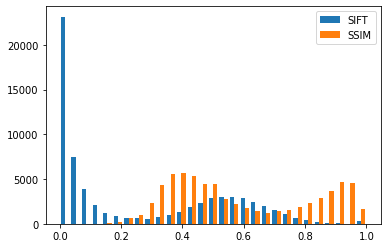

<Figure size 432x288 with 0 Axes>

In [20]:
bins = np.linspace(0,1,30)
plt.hist([trajectories.sifts,trajectories.ssims], bins, label=['SIFT','SSIM'])  # `density=False` would make counts
plt.legend(loc='upper right')
plt.show()
plt.savefig('/Users/amagill/Downloads/sift_ssim_realworld.png')